In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [2]:
def get_data():
    used_data = pd.read_csv('../data/data.csv', index_col=0, parse_dates=True)
    return used_data

def get_all_tickers():
    used_data = get_data()
    return used_data.columns

def get_returns():
    used_data = get_data()
    ret_day = ret_day = used_data.fillna(0)
    S = np.exp(used_data.fillna(0)).cumprod()
    ret_mon = S.resample('M').ffill().pct_change().dropna() # start 2000-02-29
    return ret_day, ret_mon
    
def form_labels(tic):
    # Prices and returns

    ret_day, ret_mon = get_returns()
    median_ret = ret_mon.median(1)
    labels = ret_mon.shift(-1).gt(median_ret.shift(-1), axis=0).astype(int)[tic]
    labels.name = 'label'
    return labels
    #next_isjan = (ret_mon.shift(-1).index.month == 1).astype(int)

In [3]:
def form_features(tic):
    ret_day, ret_mon = get_returns()
    
    feature_data = []
        
    daily = ret_day[tic]
    dfs = []
    idx = range(13, len(ret_mon) - 1)
    for t in idx:
        current_y = ret_mon.index[t].year
        current_mon = ret_mon.index[t].month
        next_mon_isjan = (ret_mon.index[t+1].month == 1)

        start = t - 13
        end = t - 2

        ret_mon_slice = ret_mon[tic].iloc[start:end+1]

        last_date = (daily[(daily.index.year == current_y) 
                           & (daily.index.month == current_mon)].last_valid_index())

        last_date_loc = daily.index.get_loc(last_date)
        start_date_loc = last_date_loc - 19

        daily_rets_slice = daily.iloc[start_date_loc:last_date_loc + 1]

        daily_rets_slice.index = ['R_d_' + str(i) for i in range(1, 21)]
        ret_mon_slice.index = ['R_m_' + str(i) for i in range(1, 13)]

        conc = pd.concat([daily_rets_slice, ret_mon_slice])
        conc['JAN'] = next_mon_isjan

        conc = conc.to_frame()
        conc.columns = [t]
        dfs.append(conc)
    feats_t = pd.concat(dfs, axis=1).T
    feature_data.append(feats_t)
    
    date_idx = ret_mon.index[idx]
    feature_data_df = pd.concat(feature_data, axis=0).set_index(date_idx)
    return feature_data_df

In [4]:
def form_feats_labels(tickers):
    full_data_by_tic = []
    for tic in tickers:
        feats = form_features(tic)
        labels = form_labels(tic)
        conc = pd.concat([feats, labels], axis=1, join='inner')
        full_data_by_tic.append(conc)
    return pd.concat(full_data_by_tic, axis=0) # datetime index not unique

In [44]:
def data_importer(train_set_size=0.3):
    tickers = get_all_tickers()
    data = form_feats_labels(tickers)
    X = data[data.columns[:-1]].as_matrix()
    y = data.label.as_matrix()
    
    N = len(y)
    train_set_stop = int(N * train_set_size)
    
    return X[0:train_set_stop], y[0: train_set_stop], X[train_set_stop:], y[train_set_stop:]

In [6]:
class FutureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(33, 50)
        self.fc21 = nn.Linear(50, 4)
        self.fc22 = nn.Linear(50, 4)
        self.fc3 = nn.Linear(4, 50)
        self.fc4 = nn.Linear(50, 33)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = Variable(torch.rand(std.size()), requires_grad=False)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 33))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        
    def loss_function(self, recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x.view(-1, 33), size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return MSE + KLD

In [45]:
# Train and test data
Xtrain, ytrain, Xtest, ytest = data_importer()

batch_size = 64
train_dataset = FutureDataset(Xtrain, ytrain)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = FutureDataset(Xtest, ytest)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [9]:
log_interval = 100
number_of_epochs = 500

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [10]:
vae.train()
for epoch in range(number_of_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.float())
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
    
    if (epoch+1) % log_interval == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


====> Epoch: 99 Average loss: 0.0706
====> Epoch: 199 Average loss: 0.0619
====> Epoch: 299 Average loss: 0.0595
====> Epoch: 399 Average loss: 0.0582
====> Epoch: 499 Average loss: 0.0553


In [11]:
vae.eval()
test_loss = 0
for i, (data, _) in enumerate(test_loader):
    data = Variable(data.float(), requires_grad=False)
    recon_batch, mu, logvar = vae(data)
    test_loss += vae.loss_function(recon_batch, data, mu, logvar).data[0]

test_loss /= len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

====> Test set loss: 0.0731


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [12]:
# Build encoded dataset
Xenc = np.array([]).reshape(0, 4)
yenc = np.array([])
for _, (data,target) in enumerate(train_loader):
    data = Variable(data.view(-1,33)).float()
    labels = Variable(target).type(torch.LongTensor)
    
    _, data, _ = vae(data)
    
    batch = data.cpu().data.numpy()
    Xenc = np.vstack((Xenc, batch))
    yenc = np.append(yenc, target.numpy())

In [24]:
# RANDOM FOREST CLASSIFIER
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(Xenc, yenc)
score = cross_val_score(clf, Xenc, yenc)
print(score.mean())

print("What features are prefered", clf.feature_importances_)

0.521452145215
What features are prefered [ 0.25883305  0.23334922  0.16755382  0.34026391]


In [14]:
# NAIVE BAYESIAN CLASSIFIER
gnb = GaussianNB()
gnb.fit(Xenc, yenc)
score = cross_val_score(gnb, Xenc, yenc)
print(score.mean())

0.544554455446


In [15]:
# ORGINAL DATA
tickers = get_all_tickers()
X_and_y = form_feats_labels(tickers)
Xorg = X_and_y[X_and_y.columns[:-1]].as_matrix()
yorg = X_and_y.label.as_matrix()

In [46]:
# RANDOM FOREST CLASSIFIER ONLY
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(Xtrain, ytrain)
score = cross_val_score(clf, Xtest, ytest)
print(score.mean())

print("What features are prefered: \n", clf.feature_importances_)

0.566607797383
What features are prefered: 
 [ 0.05484949  0.01222888  0.03551346  0.02605386  0.02988995  0.03855984
  0.03229935  0.04909894  0.03012636  0.02125024  0.03333895  0.05573694
  0.02418763  0.02396154  0.02687858  0.02175336  0.02706231  0.01459803
  0.02792436  0.02921282  0.04249237  0.03042023  0.02398243  0.04552304
  0.02927211  0.03401704  0.03055389  0.04590096  0.02598591  0.01867101
  0.03010383  0.02758927  0.000963  ]


In [17]:
# ADABOOST ONLY
ada = AdaBoostClassifier(n_estimators=10)
ada.fit(Xorg, yorg)  
score = cross_val_score(ada, Xorg, yorg)
print(score.mean())

0.528877887789


In [18]:
# SVC ONLY
svc = SVC(gamma=2, C=1)
svc.fit(Xorg, yorg)
score = cross_val_score(svc, Xorg, yorg)
print(score.mean())

0.509075907591


In [ ]:
# BROKEN, PREDICTION RESULTS FROM ENCODER PIPELINE
prediction_outputs = []
returns = []

classifier = clf

for idx, observation in enumerate(Xorg):
    data = torch.from_numpy(observation)

    data = Variable(data).float()
    _, data, _ = vae(data)
    output = classifier.predict_proba(data.cpu().data.numpy())
    prediction_outputs.append(output[0])

len(prediction_outputs)

In [20]:
def get_positions(prediction_outputs):
    result_df = pd.DataFrame(prediction_outputs, columns=["loser_p", "winner_p"])
    label = (result_df["winner_p"] > result_df["loser_p"]).astype(int) # <
    result_df["longshort"] = label.map({1: 1, 0: -1})

    print("Predicted long count:", sum(label))

    return result_df

In [47]:
result_dfs = {}

for tic in ["ES", "FESX", "GC", "NK", "TU", "ED"]:
    X = form_features(tic)
    prediction_outputs = clf.predict_proba(X)
    df = get_positions(prediction_outputs).set_index(X.index)
    result_dfs[tic] = df[['longshort']]

Predicted long count: 115
Predicted long count: 84
Predicted long count: 81
Predicted long count: 90
Predicted long count: 181
Predicted long count: 188


In [48]:
ret_day, ret_mon = get_returns()
ret_mon_slice = ret_mon.iloc[13:]
for key in result_dfs.keys():
    newcol = str(key) + '_pos'
    ret_mon_slice[newcol] = result_dfs[key]
ret_mon_slice = ret_mon_slice.resample('M').ffill()

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Sharpe 1.98058711982


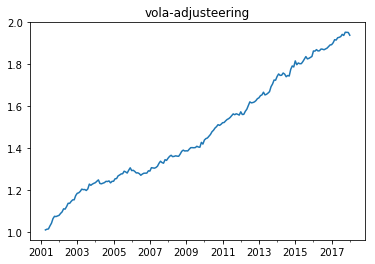

In [49]:
leverage = 0.05/(ret_day.ewm(60).std()*np.sqrt(250))
leverage_mon = leverage.resample('M').ffill()

positions = ret_mon_slice[ret_mon_slice.columns[-6:]]
returns = ret_mon_slice[ret_mon_slice.columns[:6]]
positions.columns = ['ES', 'FESX', 'GC', 'NK', 'TU', 'ED']

position_returns = returns * positions.shift(1)
vol_adj_rets = position_returns * leverage_mon.shift(1)
total_rets = vol_adj_rets.mean(1).dropna()
(total_rets + 1).cumprod().plot(title='vola-adjusteering')
m = total_rets.mean() * 12
s = total_rets.std() * np.sqrt(12)
print ('Sharpe', m/s)
plt.show()